# importing library

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
from sklearn.datasets import make_blobs
import timeit
import matplotlib.animation as animation

%matplotlib inline

# creating dataset

In [ ]:
centers = [[-2, -3], [10, 0], [5, 8]]
data, _ = make_blobs(n_samples=2000, centers=centers, n_features=2, random_state=3)
print(data.shape)

(2000, 2)


# ploting train set

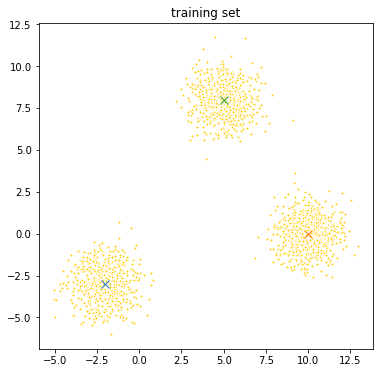

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(data[:,0], data[:, 1], 'w', markerfacecolor='#ffcc00', marker='.')
ax.plot(centers[0][0], centers[0][1], 'x', markerfacecolor='k', markersize=8)
ax.plot(centers[1][0], centers[1][1], 'x', markerfacecolor='k', markersize=8)
ax.plot(centers[2][0], centers[2][1], 'x', markerfacecolor='k', markersize=8)

ax.set_title('training set')
plt.show()


# normalizing train data

In [ ]:
from numpy.core.fromnumeric import mean
k = 2.5
h = 0.1

xmin = min(data[:,0])
xmax = max(data[:,0])
ymin = min(data[:,1])
ymax = max(data[:,1])

x_min, x_max = xmin-k, xmax+k
y_min, y_max = ymin-k, ymax+k


In [ ]:
# normalizing to 0-1
x = np.zeros_like(data)
x[:,0] = (data[:,0]-x_min)/(x_max-x_min)
x[:,1] = (data[:,1]-y_min)/(y_max-y_min)
x = x.astype('float32')

# generator network

In [ ]:
gen = tf.keras.Sequential([
                           tf.keras.layers.Dense(units=1*1*64, activation='relu', input_shape=(64,)),
                           tf.keras.layers.Dense(units=4*4, activation='relu'),
                           tf.keras.layers.Dense(units=2, activation='sigmoid')
])

gen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 5,234
Trainable params: 5,234
Non-trainable params: 0
_________________________________________________________________


# discriminator network

In [ ]:
disc = tf.keras.Sequential([
                            tf.keras.layers.InputLayer(input_shape=2),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(units=100, activation='relu'),
                            tf.keras.layers.Dense(units=10, activation='relu'),
                            tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

disc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense_5 (Dense)             (None, 100)               300       
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________


# Saving weights

In [ ]:
g_weights = gen.get_weights()
d_weights = disc.get_weights()

# denormalizing train data

In [ ]:
def denormalize(x):
  x = x.numpy()
  x[:,0] = x[:,0]*(x_max-x_min)+(x_min)
  x[:,1] = x[:,1]*(x_max-x_min)+(x_min)
  return x

# visualizations

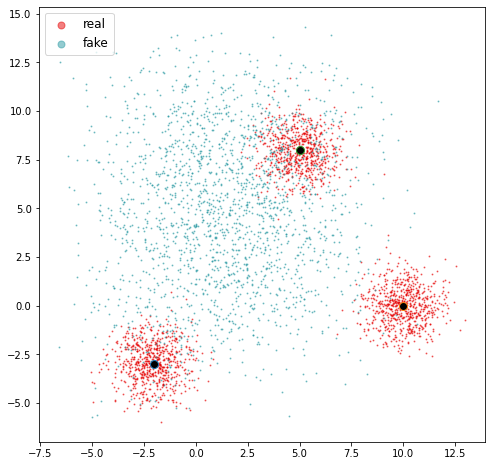

In [ ]:
z_sample = tf.random.normal([2000,64])
x_gen = gen(z_sample)
x_gen = denormalize(x_gen)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
r = ax.scatter(data[:,0], data[:,1], 4, alpha=0.5, c='#e60000', marker='.')
f = ax.scatter(x_gen[:,0], x_gen[:,1], 4, alpha=0.5, c='#2999a3', marker='.')
ax.plot(centers[0][0], centers[0][1], 'o', markerfacecolor='k', markersize=8)
ax.plot(centers[1][0], centers[1][1], 'o', markerfacecolor='k', markersize=8)
ax.plot(centers[2][0], centers[2][1], 'o', markerfacecolor='k', markersize=8)

plt.legend([r,f],['real','fake'], markerscale=7, loc='upper left', fontsize=12)
plt.show()


# optimizer

In [ ]:
gen_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

In [ ]:
print(type(x))
train_dataset =(
    tf.data.Dataset.from_tensor_slices(x).shuffle(2000).batch(batch_size = 256)
)
print(type(train_dataset))

<class 'numpy.ndarray'>
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


# loss function

In [ ]:
def gan_loss(y_true, y_pred):
  return tf.keras.losses.binary_crossentropy(y_true, y_pred)

# one step (epoch) of training

In [ ]:
@tf.function
def train_step(x):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    z_sample = tf.random.normal([x.shape[0],64])
    x_gen = gen(z_sample)
    d_fake = disc(x_gen)
    d_real = disc(x)
    d_loss = gan_loss(tf.ones_like(d_real), d_real)+gan_loss(tf.zeros_like(d_fake), d_fake)
    g_loss = gan_loss(tf.ones_like(d_fake), d_fake)

  g_gradients = gen_tape.gradient(g_loss, gen.trainable_variables)
  d_gradients = disc_tape.gradient(d_loss, disc.trainable_variables)

  gen_optimizer.apply_gradients(zip(g_gradients, gen.trainable_variables))
  disc_optimizer.apply_gradients(zip(d_gradients, disc.trainable_variables))

  return d_loss, g_loss

# training GAN

In [ ]:
g_losses = []
d_losses = []

def train(n_epochs=1, print_=False):
  for epoch in range(n_epochs):
    g_loss = []
    d_loss = []

    for batch in train_dataset:
      dloss, gloss = train_step(batch)
      g_loss.append(tf.reduce_mean(gloss))
      d_loss.append(tf.reduce_mean(dloss))
    
    g_losses.append(np.mean(g_loss))
    d_losses.append(np.mean(d_loss))

    if print_:
      print("Epoch:{} | disc:{} | gen_loss:{}".format(epoch, d_losses[-1], g_losses[-1]))

In [ ]:
train(n_epochs=5, print_=True)

Epoch:0 | disc:1.3950154781341553 | gen_loss:0.702437162399292
Epoch:1 | disc:1.3931186199188232 | gen_loss:0.700708270072937
Epoch:2 | disc:1.3911113739013672 | gen_loss:0.6993241310119629
Epoch:3 | disc:1.3883342742919922 | gen_loss:0.698561429977417
Epoch:4 | disc:1.3859339952468872 | gen_loss:0.6968287229537964
